# Jaguar Project

## 📜 Introduction

In November 2024, Jaguar officially unveiled a redesigned brand logo as part of its strategic repositioning towards electrification and modern luxury.  
This major change quickly triggered extensive discussions across social media, particularly on Reddit, where users voiced a wide range of opinions about the new visual identity.

This project aims to analyze public sentiment and key discussion themes regarding Jaguar’s logo update by leveraging Natural Language Processing (NLP) techniques.  
We collected Reddit comments related to the announcement, performed data cleaning and preprocessing, and applied sentiment analysis using two different approaches — **VADER** and **TextBlob** — to compare their performance.

**Objectives**:
- Measure the overall public sentiment towards Jaguar's rebranding.
- Compare the sensitivity of VADER and TextBlob in detecting positive, neutral, and negative sentiments.
- Identify the dominant discussion topics and frequently used keywords.
- Provide actionable insights for brand communication strategies.

The following sections present a detailed analysis combining sentiment detection, topic modeling, and keyword extraction based on the collected Reddit data.


## Data Cleaning

In [4]:
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim
from datetime import datetime
import string
import praw
from praw.models import MoreComments
import csv
import datetime
import pandas as pd
import numpy as np
import re
import pprint
pd.options.mode.chained_assignment = None

from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk import tokenize
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('averaged_perceptron_tagger')

import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
import seaborn as sns

import emoji

[nltk_data] Downloading package punkt to /Users/nicolelee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nicolelee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nicolelee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
reddit = praw.Reddit(
    client_id='MYID',
    client_secret='MYSECRECT',
    user_agent='MYAGENT',
    username='MYNAME',
    password='MYPASSWORD'
)
reddit

In [6]:
post_urls = [
    'https://www.reddit.com/r/cars/comments/1gute6f/jaguar_logo_changes_are_first_step_in_the_luxury/',
    'https://www.reddit.com/r/oddlyspecific/comments/1gx5mln/jaguars_new_logo/',
    'https://www.reddit.com/r/logodesign/comments/1guwsn1/jaguar_cars_had_a_logo_update_what_kind_of/']

In [7]:
r_posts = []
r_details = []

for url in post_urls:
    try:
        submission = reddit.submission(url=url)

        submission.comments.replace_more(limit=0)

        for comment in submission.comments.list():
            r_posts.append(comment.body) 
            r_details.append([
                comment.id,
                comment.parent_id,
                comment.author.name if comment.author else 'Deleted',
                comment.score,
                comment.created_utc
            ])

    except Exception as e:
        print(f"An error occurred while processing {url}: {e}")

df_comment = pd.DataFrame(r_posts, columns=["comment"])   
df_details = pd.DataFrame(r_details, columns=["comment_id", "parent_id", "username", "upvotes", "datetime"])


print(df_comment.head()) 
print(df_details.head())   

df_comment.to_csv('reddit_comments.csv', index=False)
df_details.to_csv('reddit_comment_details.csv', index=False)

                                             comment
0  As a former Jaguar owner, I’m here to say no, ...
1  A yes, the logos were certainly their biggest ...
2  Their transformation into a women's hand bag b...
3  The pouncing cat looks great, but the other ne...
4  Shit looks like some home decor brand. What th...
  comment_id   parent_id           username  upvotes      datetime
0    lxwuh9x  t3_1gute6f    1orange2oranges      145  1.732016e+09
1    lxwjl5j  t3_1gute6f             RBR927      537  1.732010e+09
2    lxwyf21  t3_1gute6f       argent_pixel       75  1.732018e+09
3    lxwisjb  t3_1gute6f  DodgerBlueRobert1      222  1.732009e+09
4    lxwvq3l  t3_1gute6f               t51r       38  1.732017e+09


In [8]:
#Removing Duplicated Comments (parent comments in replies), links and link markups
df_comment = pd.read_csv("reddit_comments.csv")
df_details = pd.read_csv("reddit_comment_details.csv")

In [9]:
len(df_comment)

715

In [10]:
#check for empty cells
df_comment.isna().sum()

comment    0
dtype: int64

In [11]:
#split sentences by delimited '\n\n'
df_comment['comment'] = [item.split("\n\n") for item in df_comment.comment]

#explore nested list into individual rows
df_comment = df_comment.explode("comment").rename_axis("index_name").reset_index()

#replace double space with empty string
df_comment["comment"] = df_comment.comment.str.replace("&#x200B;", "")

In [12]:
#check number of rows after exploding
len(df_comment)

939

In [13]:
#for replies with parent comments within, remove parent coment and retain replies
#those are fields with string that start with ">"
#remove bullet points
df_comment.loc[df_comment.comment.str.startswith(">")] = ""
df_comment["comment"] = [i.strip() for i in df_comment.comment]
df_comment["comment"] = [re.sub(r"^[0-9]", " ", i) for i in df_comment.comment]

/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_10514/3233326542.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_comment.loc[df_comment.comment.str.startswith(">")] = ""


In [14]:
#see table of items with https links and markup links
df_comment.loc[df_comment.comment.str.contains("https")]

,index_name,comment
4,3,Edit: I have to say though...as bad as the new...
27,15,[https://x.com/Jaguar/status/18588008466469481...
40,23,I miss 90's Jaguars (https://i.imgur.com/dKows...
45,28,Glad they’ve got the factory [issues](https://...
74,52,"I'm not a font expert, but It may be the exact..."
82,57,[Well at least they didn't go back to the old ...
154,109,[J a G U a r](https://hips.hearstapps.com/hmg-...
155,109,[Mac and cheese](https://mms.businesswire.com/...
156,110,Funny you'd say that cause there's literally a...
163,114,"The front end, yes. But not the sloping [rear ..."


In [15]:
#do a temporary table to see the usernames for these comments
df_temp_https = df_comment[df_comment.comment.str.contains("https")]
df_temp_details = df_details.reset_index()
df_temp = pd.merge(df_temp_https, df_temp_details, how = "inner", left_on = "index_name", right_on = "index")
df_temp

,index_name,comment,index,comment_id,parent_id,username,upvotes,datetime
0,3,Edit: I have to say though...as bad as the new...,3,lxwisjb,t3_1gute6f,DodgerBlueRobert1,222,1.732009e+09
1,15,[https://x.com/Jaguar/status/18588008466469481...,15,lxxp0i7,t3_1gute6f,taint_tattoo,3,1.732029e+09
2,23,I miss 90's Jaguars (https://i.imgur.com/dKows...,23,lxz35xp,t3_1gute6f,Doody-Face,2,1.732044e+09
3,28,Glad they’ve got the factory [issues](https://...,28,lxxla6z,t3_1gute6f,Deleted,1,1.732027e+09
4,52,"I'm not a font expert, but It may be the exact...",52,lynadoh,t3_1gute6f,davemsn,1,1.732400e+09
5,57,[Well at least they didn't go back to the old ...,57,lxx9om1,t3_1gute6f,Maximilianne,0,1.732023e+09
6,109,[J a G U a r](https://hips.hearstapps.com/hmg-...,109,lxwkbwv,t1_lxwjhtq,DodgerBlueRobert1,54,1.732010e+09
7,109,[Mac and cheese](https://mms.businesswire.com/...,109,lxwkbwv,t1_lxwjhtq,DodgerBlueRobert1,54,1.732010e+09
8,110,Funny you'd say that cause there's literally a...,110,lxwxcbz,t1_lxwnoy7,aPardawala,21,1.732018e+09
9,114,"The front end, yes. But not the sloping [rear ...",114,lxyszn9,t1_lxxv8qg,DodgerBlueRobert1,1,1.732041e+09


In [16]:
#define function to remove both links and markup links
#also remove '\' from dont\'t
def remove_https(item):
    #remove https links
    item_1 = re.sub(r"[(+*)]\S*https?:\S*[(+*)]", "", item)
    #remove https links with no brackets
    item_2 = re.sub('http://\S+|https://\S+', " ", item_1)
    #remove link markups []
    item_3 = re.sub(r"[\(\[].*?[\)\]]", " ", item_2)
     #remove \ in don\'t
    item_4 = re.sub("[\"\']", "'", item_3)
    return item_4

df_comment["comment"] = [remove_https(x) for x in df_comment.comment]

<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_10514/743049754.py:7: SyntaxWarning: invalid escape sequence '\S'
  item_2 = re.sub('http://\S+|https://\S+', " ", item_1)


In [17]:
#check the temporary table to see if links/ markuplinks/ \' 
#all links has been removed
#unecessary comments (highlighted in yellow) can be removed later by filtering out unecessary usernames
df_temp["comment"] = [remove_https(x) for x in df_temp.comment]
df_temp.style.apply(lambda x: ['background: lightyellow' if x.username == "RemindMeBot" \
                               or x.username =="sneakpeek_bot" else '' for i in x], axis=1)

,index_name,comment,index,comment_id,parent_id,username,upvotes,datetime
0,3,"Edit: I have to say though...as bad as the new logos may be, There might be hope yet. And if their new logos get a lot of bad press, they could always change it back to something good.",3,lxwisjb,t3_1gute6f,DodgerBlueRobert1,222,1732009176.000000
1,15,[,15,lxxp0i7,t3_1gute6f,taint_tattoo,3,1732028631.000000
2,23,I miss 90's Jaguars,23,lxz35xp,t3_1gute6f,Doody-Face,2,1732043668.000000
3,28,Glad they’ve got the factory sorted so they can focus on the real issues at hand here.,28,lxxla6z,t3_1gute6f,Deleted,1,1732027398.000000
4,52,"I'm not a font expert, but It may be the exact same font, especially the 'a' that's used for See what you think.",52,lynadoh,t3_1gute6f,davemsn,1,1732400036.000000
5,57,,57,lxx9om1,t3_1gute6f,Maximilianne,0,1732023204.000000
6,109,,109,lxwkbwv,t1_lxwjhtq,DodgerBlueRobert1,54,1732010207.000000
7,109,,109,lxwkbwv,t1_lxwjhtq,DodgerBlueRobert1,54,1732010207.000000
8,110,Funny you'd say that cause there's literally a bathroom fitment company named,110,lxwxcbz,t1_lxwnoy7,aPardawala,21,1732017876.000000
9,114,"The front end, yes. But not the sloping profile.",114,lxyszn9,t1_lxxv8qg,DodgerBlueRobert1,1,1732040673.000000


In [18]:
#check number of rows
len(df_comment)

939

In [19]:
#implode and remove column index_name
df_comment_1 = df_comment.groupby("index_name")["comment"].apply(lambda x: " ".join(x)).reset_index().drop("index_name", axis = 1)

In [20]:
#check that total columns are still the same before explode
#seems that there is additional row 
len(df_comment_1)

716

In [21]:
#last row is the additional empty row
df_comment_1.tail()

,comment
711,Yes. If you know you know. Otherwise leave it be.
712,Thank you for the insight!
713,I left weeks before lockdown by coincidence it...
714,Thank you. I had a feeling it was. I'll keep m...
715,


In [22]:
#remove the last row by slicing 
df_comment_1 = df_comment_1[:718]

In [23]:
#Removing deleted / bot useraccounts and empty comment
df = pd.concat([df_comment_1, df_details], axis = 1)
df

,comment,comment_id,parent_id,username,upvotes,datetime
0,"As a former Jaguar owner, I’m here to say no, ...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
1,"A yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09
2,Their transformation into a women's hand bag b...,lxwyf21,t3_1gute6f,argent_pixel,75.0,1.732018e+09
3,"The pouncing cat looks great, but the other ne...",lxwisjb,t3_1gute6f,DodgerBlueRobert1,222.0,1.732009e+09
4,Shit looks like some home decor brand. What th...,lxwvq3l,t3_1gute6f,t51r,38.0,1.732017e+09
...,...,...,...,...,...,...
711,Yes. If you know you know. Otherwise leave it be.,ly2z3w3,t1_lxz14br,Spikas,1.0,1.732101e+09
712,Thank you for the insight!,lxzwptx,t1_lxz1v23,ohhh_blackbetty,1.0,1.732053e+09
713,I left weeks before lockdown by coincidence it...,lxzznos,t1_lxzuwad,AwayFirefighter5807,1.0,1.732054e+09
714,Thank you. I had a feeling it was. I'll keep m...,lxz9dhx,t1_lxz8i94,Captain_Usopp,4.0,1.732046e+09


In [24]:
#see how many rows
len(df[df.comment == " "])

7

In [25]:
df[df.comment == " "]

,comment,comment_id,parent_id,username,upvotes,datetime
54,,lzk178b,t3_1gute6f,Deleted,1.0,1.732887e+09
57,,lxx9om1,t3_1gute6f,Maximilianne,0.0,1.732023e+09
59,,lxwv9oc,t1_lxwuh9x,Deleted,56.0,1.732017e+09
125,,lxx5lqx,t1_lxx3v27,Deleted,17.0,1.732022e+09
464,,lxys3pk,t3_1guwsn1,faboideae,1.0,1.732040e+09
583,,lybkmji,t3_1guwsn1,ObsiGamer,1.0,1.732228e+09
657,,lxy99hn,t1_lxy84qe,swedishpiehole,1.0,1.732035e+09


In [26]:
#remove rows with empty field under comment attribute 
df = df[df.comment != " "]

In [27]:
#username is none == useraccount that has been deleted
#seems like deleted accounts has comments that is not removed
#we will leave these accounts alone 
df[df.username.isna()]

,comment,comment_id,parent_id,username,upvotes,datetime
715,,NaN,NaN,NaN,NaN,NaN


In [28]:
df[(df.username == "RemindMeBot") | (df.username == "sneakpeek_bot")]

,comment,comment_id,parent_id,username,upvotes,datetime


In [29]:
df.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,"As a former Jaguar owner, I’m here to say no, ...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
1,"A yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09
2,Their transformation into a women's hand bag b...,lxwyf21,t3_1gute6f,argent_pixel,75.0,1.732018e+09
3,"The pouncing cat looks great, but the other ne...",lxwisjb,t3_1gute6f,DodgerBlueRobert1,222.0,1.732009e+09
4,Shit looks like some home decor brand. What th...,lxwvq3l,t3_1gute6f,t51r,38.0,1.732017e+09


In [30]:
len(df)

709

In [31]:
#Text Clean-UP
#ensure that comment attribute is of correct data type
df["comment"] = df.comment.astype("str")
df["comment"] = [item.lower() for item in df.comment]

#remove apostrophe at the beginning and end of each word (e.g. 'like, 'this, or', this')
df["comment"] = [re.sub(r"(\B'\b)|(\b'\B)", ' ', item) for item in df.comment]
df["comment"] = [re.sub(r'…', ' ', item) for item in df.comment]
df["comment"] = [item.replace('\\',' ') for item in df.comment]
df["comment"] = [item.replace('/',' ') for item in df.comment]

In [32]:
#TEST
#have a overview/ general sensing of types of contractions we have 
#create a temp list of tokenized sentences 
df_token_temp = [item.split() for item in df["comment"]]
df_token_temp = [i for word in df_token_temp for i in word]
df_contraction_temp = [re.findall("(?=\S*['-])([a-zA-Z'-]+)", i) for i in df_token_temp]
df_contraction_temp_1 = [i for item in df_contraction_temp if item != [] for i in item]
df_contraction_temp_2 = [i for n, i in enumerate(df_contraction_temp_1) if i not in df_contraction_temp_1[:n]]
print(df_contraction_temp_2)

['all-new', 'old-farts', "women's", "they're", "doesn't", 'ultra-luxury', "can't", "jaguar's", 'e-type', "weren't", "won't", 'f-type', "don't", '-', "i'm", "city's", "'s", "there's", "royce's", "bentley's", "it's", "who'd", "wasn't", "that's", "jag's", 'high-end', "isn't", "ain't", 'broke', "'", "they've", 'like', "i'd", "haven't", "they'll", "it'll", 'ready-to-wear', "you've", 'mercedes-benz', "ev's", 'tesla-owning-elon-haters', "aren't", 'v', "didn't", "you're", "you'd", 'culture-obsessed', 'all-in', 'k-', 'un-catered', 'ass-adoption', 'mass-adoption', "ceo's", "baby's", "would've", '-series', 'ultra-rich', 'soon-to-be-past', 'f-', "tesla's", "he's", "cadillac's", 's-class', "we'll", "could've", 'over-the-top', 'e-car', "which's", "what's", 'copy-paste', 'post-creative', 'post-courageous', 'jag-goo-are', 'j-a-g-w-i-r-e', "mcdonald's", "should've", 'you', 'pre-order', "they'd", '--', 'anyways', 'in-house', 'one-pager', 'fair-trade', "everything's", "who'll", 'middle-aged', "we're", "d

<>:6: SyntaxWarning: invalid escape sequence '\S'
<>:6: SyntaxWarning: invalid escape sequence '\S'
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_10514/782415577.py:6: SyntaxWarning: invalid escape sequence '\S'
  df_contraction_temp = [re.findall("(?=\S*['-])([a-zA-Z'-]+)", i) for i in df_token_temp]


In [33]:
def decontract(phrase):
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'s", "", phrase)
    phrase = re.sub(r"\'ing", "", phrase)
    
    phrase = re.sub(r"can’t", "cannot", phrase)
    phrase = re.sub(r"won’t", "will not", phrase)
    phrase = re.sub(r"let’s", "let us", phrase)
    phrase = re.sub(r"n’t", " not", phrase)
    phrase = re.sub(r"’m", " am", phrase)
    phrase = re.sub(r"’ll", " will", phrase)
    phrase = re.sub(r"’re", " are", phrase)
    phrase = re.sub(r"’d", " would", phrase)
    phrase = re.sub(r"’ve", " have", phrase)
    phrase = re.sub(r"’s", "", phrase)

    phrase = re.sub(r"all-new", "all new", phrase)
    phrase = re.sub(r"low-key", "low key", phrase)
    phrase = re.sub(r"old-money", "old money", phrase)
    phrase = re.sub(r"old-farts", "old farts", phrase)
    phrase = re.sub(r"ultra-luxury", "ultra luxury", phrase)
    phrase = re.sub(r"e-type", "e type", phrase)
    phrase = re.sub(r"f-pace", "f pace", phrase)
    phrase = re.sub(r"doesn't", "does not", phrase)
    phrase = re.sub(r"isn't", "is not", phrase)
    phrase = re.sub(r"they're", "they are", phrase)
    phrase = re.sub(r"’ing", "", phrase)
    return phrase


In [34]:
#TEST
df_contraction_temp_3 = [decontract(i) for i in df_contraction_temp_2]
print(df_contraction_temp_3)

['all new', 'old farts', 'women', 'they are', 'does not', 'ultra luxury', 'cannot', 'jaguar', 'e type', 'were not', 'will not', 'f-type', 'do not', '-', 'i am', 'city', '', 'there', 'royce', 'bentley', 'it', 'who would', 'was not', 'that', 'jag', 'high-end', 'is not', 'ai not', 'broke', "'", 'they have', 'like', 'i would', 'have not', 'they will', 'it will', 'ready-to-wear', 'you have', 'mercedes-benz', 'ev', 'tesla-owning-elon-haters', 'are not', 'v', 'did not', 'you are', 'you would', 'culture-obsessed', 'all-in', 'k-', 'un-catered', 'ass-adoption', 'mass-adoption', 'ceo', 'baby', 'would have', '-series', 'ultra-rich', 'soon-to-be-past', 'f-', 'tesla', 'he', 'cadillac', 's-class', 'we will', 'could have', 'over-the-top', 'e-car', 'which', 'what', 'copy-paste', 'post-creative', 'post-courageous', 'jag-goo-are', 'j-a-g-w-i-r-e', 'mcdonald', 'should have', 'you', 'pre-order', 'they would', '--', 'anyways', 'in-house', 'one-pager', 'fair-trade', 'everything', 'who will', 'middle-aged', '

In [35]:
#decontract words in dataframe
df["comment"] = [decontract(i) for i in df.comment]

In [36]:
#define a function to find all emojis
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

In [37]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

# Extract the list of emojis to convert
emoji_lst = [extract_emojis(i) for i in df.comment.tolist()]
emoji_lst = list(filter(None, emoji_lst))
emoji_lst 

['💰',
 '🤨',
 '🤮',
 '🎯',
 '😂',
 '🤣',
 '😂👍',
 '😭',
 '🚗',
 '🤮',
 '🥺',
 '😂',
 '😄',
 '©',
 '🤦🏻',
 '😂',
 '👀😂',
 '😂',
 '😂😂😂',
 '😂',
 '😂',
 '🤷🏽♂',
 '🤣',
 '😂']

In [38]:
# Define a function that converts emojis to words/phrases
def convert_emoji(phrase):
    phrase = re.sub(r"💰", " money ", phrase)
    phrase = re.sub(r"🤨", " not confident ", phrase)
    phrase = re.sub(r"🤮", " disgusting ", phrase)
    phrase = re.sub(r"🎯", " target ", phrase)
    phrase = re.sub(r"😂", " laugh ", phrase)
    phrase = re.sub(r"🤣", " laughing hard ", phrase)
    phrase = re.sub(r"😂👍", " laughing with approval ", phrase)
    phrase = re.sub(r"😭", " crying ", phrase)
    phrase = re.sub(r"🚗", " car ", phrase)
    phrase = re.sub(r"🥺", " pleading face ", phrase)
    phrase = re.sub(r"😄", " happy ", phrase)
    phrase = re.sub(r"©", " copyright ", phrase)
    phrase = re.sub(r"🤦🏻", " facepalm ", phrase)
    phrase = re.sub(r"👀😂", " laughing with eyes wide open ", phrase)
    phrase = re.sub(r"😂😂😂", " laughing uncontrollably ", phrase)
    phrase = re.sub(r"🤷🏽♂", " shrugging man ", phrase)
    phrase = re.sub(r"👍", " thumbs up ", phrase)
    phrase = re.sub(r"👀", " eyes ", phrase)
    phrase = re.sub(r"🔥", " fire ", phrase)
    
    return phrase

# Apply the function to the 'comment' column
df["comment"] = [convert_emoji(i) for i in df.comment]

In [39]:
#define a function that converts all typos
def clean_typo(phrase):
    phrase = re.sub(r"oldfarts", "old farts", phrase)
    phrase = re.sub(r"thoughas", "though as", phrase)
    phrase = re.sub(r"typefaceones", " typeface ones ", phrase)
    phrase = re.sub(r"vehicleeryone", "vehicle everyone", phrase)
    phrase = re.sub(r"relelectric", "real electric", phrase)
    phrase = re.sub(r"vehicleant", "vehicle and", phrase)
    phrase = re.sub(r" apeopleiances ", "appliances", phrase)
    phrase = re.sub(r" vehicleerybody ", " vehicle everybody ", phrase)
    phrase = re.sub(r" vehicleen ", " vehicle even ", phrase)
    phrase = re.sub(r" inelectric ", " in electric ", phrase)
    phrase = re.sub(r" vehicleitable ", " vehicle suitable ", phrase)
    phrase = re.sub(r" jquqr ", " jaguar ", phrase)
    phrase = re.sub(r" vehicleer ", " cbd ", phrase)
    phrase = re.sub(r" vehiclee ", " vehicle ", phrase)
    phrase = re.sub(r" jadore ", " jaguar ", phrase)
    phrase = re.sub(r" jaguarthe ", " jaguar the ", phrase)
    phrase = re.sub(r" vehicleerything ", " vehicle ", phrase)
    phrase = re.sub(r" vehicleery ", " vehicle ", phrase)
    phrase = re.sub(r" vehicleeryone ", " vehicle ", phrase)
    phrase = re.sub(r" vehiclesit ", " vehicle sit ", phrase)
    phrase = re.sub(r" vehicleious ", " vehicle ", phrase)
    phrase = re.sub(r" vehiclea ", " vehicle ", phrase)
    phrase = re.sub(r" vehicley ", " vehicle ", phrase)
    phrase = re.sub(r" vehicleity ", " vehicle ", phrase)
    phrase = re.sub(r" vehicleious ", " vehicle ", phrase)
    phrase = re.sub(r" vehicleiew ", " vehicle ", phrase)
    phrase = re.sub(r" vehicleices ", " vehicle ", phrase)
    return phrase
    
df["comment"] = [clean_typo(i) for i in df.comment]

In [40]:
#define a function to convert all short-forms/ short terms 
def clean_short(phrase):
    phrase = re.sub(r"fyi", "for your information", phrase)
    phrase = re.sub(r" ngl ", " not going to lie ", phrase)
    phrase = re.sub(r"tbh", "to be honest", phrase)
    phrase = re.sub(r" esp ", " especially ", phrase)
    phrase = re.sub(r" info ", "information", phrase)
    phrase = re.sub(r"gonna", "going to", phrase)
    phrase = re.sub(r"stats", "statistics", phrase)
    phrase = re.sub(r"rm ", " room ", phrase)
    phrase = phrase.replace("i.e.", " ")
    phrase = re.sub(r"idk", "i do not know", phrase)
    phrase = re.sub(r"haha", "laugh", phrase)
    phrase = re.sub(r"yr", " year", phrase)
    phrase = re.sub(r" sg ", " singapore ", phrase)
    phrase = re.sub(r" mil ", " million ", phrase)
    phrase = re.sub(r" =", " same ", phrase)
    phrase = re.sub(r" msr. ", " mortage serving ratio ", phrase)
    phrase = re.sub(r" eip ", " ethnic integration policy ", phrase)
    phrase = re.sub(r" g ", " government ", phrase)
    phrase = re.sub(r"imo", "in my opinion", phrase)
    phrase = re.sub(r" pp ", " private property ", phrase)
    phrase = re.sub(r" grad ", " graduate ", phrase)
    phrase = re.sub(r" ns ", " national service ", phrase)
    phrase = re.sub(r" bc ", " because ", phrase)
    phrase = re.sub(r" u ", " you ", phrase)
    phrase = re.sub(r" ur ", " your ", phrase)
    phrase = re.sub(r"^yo ", " year ", phrase)
    phrase = re.sub(r" vs ", " versus ", phrase)
    phrase = re.sub(r" irl ", " in reality ", phrase)
    phrase = re.sub(r" tfr ", " total fertility rate ", phrase)
    phrase = re.sub(r" fk ", " fuck ", phrase)
    phrase = re.sub(r" fked ", " fuck ", phrase)
    phrase = re.sub(r" fucked ", " fuck ", phrase)
    phrase = re.sub(r".  um.", " cynical. ", phrase)
    phrase = re.sub(r" pre-", " before ", phrase)
    phrase = re.sub(r" ed ", " education ", phrase)
    phrase = re.sub(r"lmao", "laughing my ass off", phrase)
    phrase = re.sub(r"wtf", "what the fuck", phrase)
    phrase = re.sub(r"lol", "laugh out loud", phrase)
    phrase = re.sub(r"ev", "electric vehicle", phrase)
    phrase = re.sub(r"instragram", "Instagram", phrase)
    phrase = re.sub(r"ofc", "of course", phrase)
    phrase = re.sub(r"ppl", "people", phrase)
    phrase = re.sub(r"sry", "sorry", phrase)
    phrase = re.sub(r"joguor", "jaguar", phrase)
    phrase = re.sub(r"jragruar", "jaguar", phrase)
    phrase = re.sub(r"joguor", "jaguar", phrase)
    phrase = re.sub(r"jaquar", "jaguar", phrase)
    phrase = re.sub(r"omg", "oh my god", phrase)
    phrase = re.sub(r"tiktok", "TikTok", phrase)
    phrase = re.sub(r" kia ", " KIA ", phrase)
    phrase = re.sub(r" kias ", " KIA ", phrase)
    phrase = re.sub(r" Kia ", " KIA ", phrase)
    return phrase

df["comment"] = [clean_short(i) for i in df.comment]

In [41]:
df.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,"as a former jaguar owner, i am here to say no,...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
1,"a yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09
2,their transformation into a women hand bag bra...,lxwyf21,t3_1gute6f,argent_pixel,75.0,1.732018e+09
3,"the pouncing cat looks great, but the other ne...",lxwisjb,t3_1gute6f,DodgerBlueRobert1,222.0,1.732009e+09
4,shit looks like some home decor brand. what th...,lxwvq3l,t3_1gute6f,t51r,38.0,1.732017e+09


## Text Analysis
In this section, we performed sentiment analysis on Reddit comments using two different NLP methods: **VADER** and **TextBlob**.

### 1. Sentiment Analysis with VADER
- **Tool**: VADER (Valence Aware Dictionary and sEntiment Reasoner)
- **Approach**: Sentence-level sentiment analysis using the compound polarity score.
- **Sentiment Categorization**:
  - Positive: compound score > 0.05
  - Negative: compound score < -0.05
  - Neutral: otherwise
- **Observation**:
  - VADER was able to detect a significant number of negative sentiments, indicating its sensitivity to informal and emotionally charged expressions often found in Reddit comments.

### 2. Sentiment Analysis with TextBlob
- **Tool**: TextBlob
- **Approach**: Sentence-level sentiment analysis using polarity and subjectivity scores.
- **Sentiment Categorization**:
  - Positive: polarity > 0
  - Negative: polarity < 0
  - Neutral: polarity = 0
- **Observation**:
  - TextBlob classified a larger portion of comments as neutral compared to VADER, reflecting its more conservative and less context-sensitive nature.

### 3. Comparative Insights
| Aspect                  | VADER                                 | TextBlob                             |
|-------------------------|--------------------------------------|--------------------------------------|
| Sensitivity to Negative | High (detects more negative comments) | Lower (more comments labeled neutral) |
| Handling Informal Text  | Good (designed for social media)      | Basic (sensitive to proper grammar)   |
| Neutral Bias            | Lower                                 | Higher                               |

**Summary**:  
VADER captured more emotional polarity, especially negative sentiment, while TextBlob tended to assess comments as neutral. This highlights the importance of choosing the right sentiment tool based on the nature of the text data.

The following visualizations illustrate the sentiment distribution results obtained from both methods.


### VADER

In [44]:
df_sentiment_vader = df
df_sentiment_vader.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,"as a former jaguar owner, i am here to say no,...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
1,"a yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09
2,their transformation into a women hand bag bra...,lxwyf21,t3_1gute6f,argent_pixel,75.0,1.732018e+09
3,"the pouncing cat looks great, but the other ne...",lxwisjb,t3_1gute6f,DodgerBlueRobert1,222.0,1.732009e+09
4,shit looks like some home decor brand. what th...,lxwvq3l,t3_1gute6f,t51r,38.0,1.732017e+09


In [45]:
# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Separate each comment into individual sentences
df_sentiment_vader['comment'] = [sent_tokenize(item) for item in df_sentiment_vader.comment]

# Split each sentence into individual rows
df_sentiment_vader_1 = df_sentiment_vader.explode("comment").reset_index(drop=True)

In [46]:
# Updated function to handle sentiment analysis with VADER
def get_sentiment_vader(text):
    if not isinstance(text, str):  # Check if input is not a string
        return {"polarity": None, "subjectivity": None, "sentiment": None}
    
    sentiment_score = sia.polarity_scores(text)
    sentiment_polarity = sentiment_score['compound']
    
    # Determine sentiment label
    if sentiment_polarity > 0.05:
        sentiment_label = "positive"
    elif sentiment_polarity < -0.05:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    
    # Store result in a dictionary
    result = {
        "polarity": sentiment_polarity,
        "subjectivity": None,  # VADER doesn't provide subjectivity
        "sentiment": sentiment_label,
    }
    return result

In [47]:
# Convert the column to strings and handle NaN values
df_sentiment_vader_1["comment"] = df_sentiment_vader_1["comment"].astype(str)

# Apply the updated function to the column
df_sentiment_vader_1["sentiment_result"] = df_sentiment_vader_1["comment"].apply(get_sentiment_vader)

In [48]:
# Flatten the sentiment_result dictionary into separate columns
sentiment = pd.json_normalize(df_sentiment_vader_1["sentiment_result"])

In [49]:
# Concatenate both dataframes together horizontally
df_vader_1 = pd.concat([df_sentiment_vader_1, sentiment], axis=1)
df_vader_1.head()

,comment,comment_id,parent_id,username,upvotes,datetime,sentiment_result,polarity,subjectivity,sentiment
0,"as a former jaguar owner, i am here to say no,...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09,"{'polarity': -0.5267, 'subjectivity': None, 's...",-0.5267,None,negative
1,the new logo type feels like it wants to be at...,lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09,"{'polarity': 0.3612, 'subjectivity': None, 'se...",0.3612,None,positive
2,"now, it might be that they want all new client...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09,"{'polarity': 0.1245, 'subjectivity': None, 'se...",0.1245,None,positive
3,"a yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09,"{'polarity': 0.6249, 'subjectivity': None, 'se...",0.6249,None,positive
4,glad they got those fixed first.,lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09,"{'polarity': 0.4588, 'subjectivity': None, 'se...",0.4588,None,positive


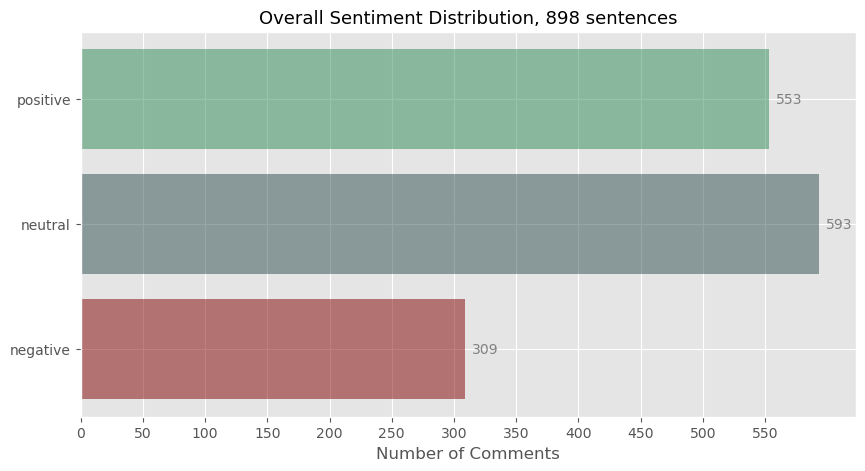

In [50]:
# Plot sentiment distribution
plt.style.use("ggplot")

positive = len(df_vader_1[df_vader_1.sentiment == "positive"])
negative = len(df_vader_1[df_vader_1.sentiment == "negative"])
neutral = len(df_vader_1[df_vader_1.sentiment == "neutral"])

sentiment = [positive, neutral, negative]
sentiment_cat = ["positive", "neutral", "negative"]

sentiment.reverse()
sentiment_cat.reverse()

fig, ax = plt.subplots(figsize=(10, 5))

palette = ["maroon", "darkslategrey", "seagreen"]

hbars = plt.barh(sentiment_cat, sentiment, color=palette, alpha=0.5)

ax.bar_label(hbars, fmt='%.0f', color="grey", padding=5)

plt.xticks(np.arange(0, 560, 50).tolist())

plt.xlabel("Number of Comments")
plt.title("Overall Sentiment Distribution, 898 sentences", size=13)
plt.show()

#### 📊 VADER Sentiment Distribution

This bar chart displays the overall sentiment distribution of 898 sentences analyzed using the VADER sentiment analyzer.

#### 🔍 Observations:
- **Neutral comments** form the largest group with 593 sentences.
- **Positive comments** are also substantial, with 553 sentences.
- **Negative comments** are fewer, with 309 sentences, but still significant.

Despite VADER's sensitivity to negative language typically found in informal text, neutral and positive sentiments remain dominant in this dataset.

**Summary**:
The sentiment towards Jaguar’s logo change on Reddit, as assessed by VADER, appears mostly neutral to slightly positive, with a noticeable but smaller fraction of negative reactions.


### TextBlob

In [53]:
df_sentiment = df
df_sentiment['comment'] = df_sentiment['comment'].apply(lambda x: ' '.join(x))

In [54]:
df_sentiment.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,"as a former jaguar owner, i am here to say no,...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
1,"a yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09
2,their transformation into a women hand bag bra...,lxwyf21,t3_1gute6f,argent_pixel,75.0,1.732018e+09
3,"the pouncing cat looks great, but the other ne...",lxwisjb,t3_1gute6f,DodgerBlueRobert1,222.0,1.732009e+09
4,shit looks like some home decor brand. what th...,lxwvq3l,t3_1gute6f,t51r,38.0,1.732017e+09


In [55]:
#separate each comment into individual sentences
df_sentiment['comment'] = [tokenize.sent_tokenize(item) for item in df_sentiment.comment]

In [56]:
#split each sentence into individual rows
df_sentiment_1 = df_sentiment.explode("comment").reset_index(drop = True)

In [57]:
df_sentiment_1.head()

,comment,comment_id,parent_id,username,upvotes,datetime
0,"as a former jaguar owner, i am here to say no,...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
1,the new logo type feels like it wants to be at...,lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
2,"now, it might be that they want all new client...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09
3,"a yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09
4,glad they got those fixed first.,lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09


In [58]:
#define a function to obtain get polariy and subjectivity

def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity 
    sentiment_subjectivity = blob.sentiment.subjectivity 
    if sentiment_polarity > 0:
        sentiment_label = "positive"
    elif sentiment_polarity < 0:
        sentiment_label = "negative"
    else:
        sentiment_label = "neutral"
    #store result in a dictionary
    result = {"polarity": sentiment_polarity, 
             "subjectivity": sentiment_subjectivity,
             "sentiment": sentiment_label}
    return result  

In [59]:
def get_sentiment(text):
    text = str(text) if not isinstance(text, str) else text
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity


In [60]:
#apply function and create new column to store result
df_sentiment_1["sentiment_result"] = df_sentiment_1.comment.apply(get_sentiment)

In [61]:
#split result (stored as dictionary) into individual key columns 
sentiment = pd.json_normalize(df_sentiment_1["sentiment_result"])

In [62]:
#concatenate both dataframe together horizontally
df_1 = pd.concat([df_sentiment_1,sentiment], axis = 1)
df_1.head()

,comment,comment_id,parent_id,username,upvotes,datetime,sentiment_result
0,"as a former jaguar owner, i am here to say no,...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09,"(0.0, 0.0)"
1,the new logo type feels like it wants to be at...,lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09,"(0.16818181818181818, 0.2772727272727273)"
2,"now, it might be that they want all new client...",lxwuh9x,t3_1gute6f,1orange2oranges,145.0,1.732016e+09,"(0.29659090909090907, 0.5511363636363636)"
3,"a yes, the logos were certainly their biggest ...",lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09,"(0.21428571428571427, 0.5714285714285714)"
4,glad they got those fixed first.,lxwjl5j,t3_1gute6f,RBR927,537.0,1.732010e+09,"(0.2833333333333333, 0.5111111111111111)"


In [63]:
def label_sentiment(sentiment_tuple):
    if pd.isnull(sentiment_tuple):
        return "neutral"
    polarity, _ = sentiment_tuple  # unpack the (polarity, subjectivity) tuple
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

df_1["sentiment"] = df_1["sentiment_result"].apply(label_sentiment)

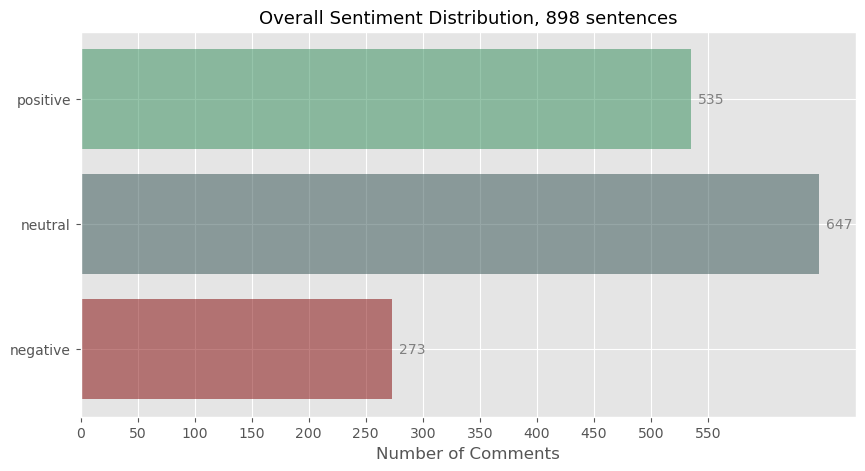

In [64]:
plt.style.use("ggplot")

positive = len(df_1[df_1.sentiment == "positive"])
negative = len(df_1[df_1.sentiment == "negative"])
neutral = len(df_1[df_1.sentiment == "neutral"])

sentiment = [positive, neutral, negative]
sentiment_cat = ["positive", "neutral", "negative"]

sentiment.reverse()
sentiment_cat.reverse()

fig, ax = plt.subplots(figsize=(10,5))

palette = ["maroon", "darkslategrey", "seagreen"]

hbars = plt.barh(sentiment_cat, sentiment, color = palette, alpha = 0.5)

ax.bar_label(hbars, fmt='%.0f', color = "grey", padding = 5)

plt.xticks(np.arange(0,560,50).tolist())

plt.xlabel("Number of Comments")
plt.title("Overall Sentiment Distribution, 898 sentences", size = 13)
plt.show()

#### 📊 TextBlob Sentiment Distribution

This bar chart displays the overall sentiment distribution of 898 sentences analyzed using the TextBlob sentiment analyzer.

#### 🔍 Observations:
- **Neutral sentences** are the largest group, with 647 occurrences.
- **Positive sentences** account for 535 instances.
- **Negative sentences** are the smallest group, with 273 instances.

Compared to VADER, TextBlob assigned a significantly higher number of comments to the neutral category. This reflects TextBlob’s more conservative nature in detecting polarity, particularly in social media text.

**Summary**:
The sentiment towards Jaguar’s logo change, as assessed by TextBlob, appears predominantly neutral, with relatively less negative sentiment detected compared to the VADER analysis.


### Time Analysis

In [67]:
#converting date to appropriate dtypes
df_1["datetime"] = pd.to_datetime(df_1.datetime, unit = "s")
df_1["date"] = df_1["datetime"].dt.date
df_1["hour"] = df_1["datetime"].dt.hour

In [68]:
df_date = df_1.groupby(["date", "sentiment"])["comment"].count().reset_index(name = "total_comment")
df_date.style.apply(lambda x: ['background: lightyellow' if x.total_comment < 40 \
                               else '' for i in x], axis=1)

,date,sentiment,total_comment
0,2024-11-19,negative,127
1,2024-11-19,neutral,309
2,2024-11-19,positive,269
3,2024-11-20,negative,28
4,2024-11-20,neutral,111
5,2024-11-20,positive,55
6,2024-11-21,negative,14
7,2024-11-21,neutral,28
8,2024-11-21,positive,22
9,2024-11-22,negative,75


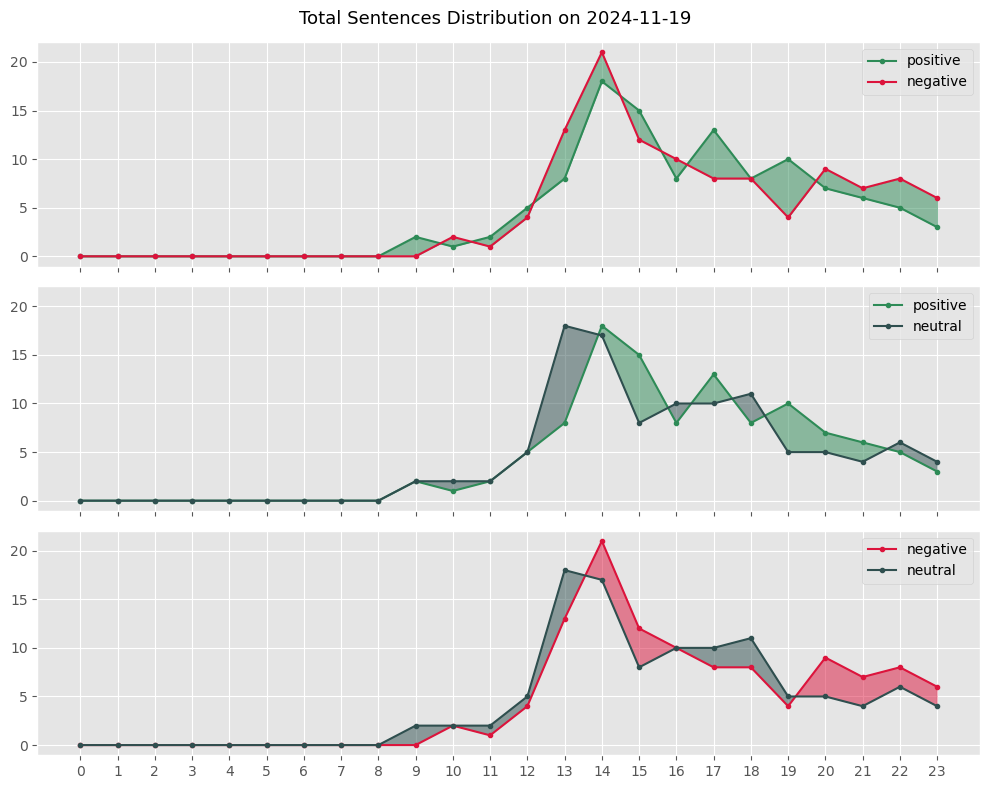

In [69]:
# Convert the Unix timestamp to a datetime object
df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

# Extract date and hour
df['date'] = df['datetime'].dt.date
df['hour'] = df['datetime'].dt.hour

# Simulate a 'sentiment' column (if not present in your dataset)
np.random.seed(42)  # Ensure reproducibility
df['sentiment'] = np.random.choice(['positive', 'negative', 'neutral'], size=len(df))

# Add a placeholder 'comment' column to count comments for each sentiment
df['comment'] = 1

# Create a DataFrame of all dates and hours
unique_dates = df['date'].unique()
hours = np.arange(0, 24, 1)
df_total_date = pd.DataFrame(unique_dates, columns=["date"])
df_total_hour = pd.DataFrame(hours, columns=["hour"])
df_total_hour_date = pd.merge(df_total_date, df_total_hour, how="cross")

# Group data by sentiment and merge with all date-hour combinations
sentiments = ['positive', 'negative', 'neutral']
sentiment_data = {}

for sentiment in sentiments:
    temp_df = df[df['sentiment'] == sentiment]
    merged_df = pd.merge(df_total_hour_date, temp_df, how="left", on=["date", "hour"])
    grouped = merged_df.groupby(["date", "hour"])["comment"].count().reset_index(name="total_comment")
    sentiment_data[sentiment] = grouped

# Select a specific date for plotting
selected_date = unique_dates[0]  # Example: first date in the dataset
sentiment_date_data = {s: d[d['date'] == selected_date] for s, d in sentiment_data.items()}

# Fill NaN values in 'total_comment' with 0
for sentiment in sentiment_date_data:
    sentiment_date_data[sentiment]['total_comment'] = sentiment_date_data[sentiment]['total_comment'].fillna(0)

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 8))
colors = {"positive": "seagreen", "negative": "crimson", "neutral": "darkslategrey"}

# Plot positive vs negative
axes[0].plot(sentiment_date_data['positive']['hour'], sentiment_date_data['positive']['total_comment'],
             label='positive', color=colors['positive'], marker='o', markersize=3)
axes[0].plot(sentiment_date_data['negative']['hour'], sentiment_date_data['negative']['total_comment'],
             label='negative', color=colors['negative'], marker='o', markersize=3)
axes[0].fill_between(sentiment_date_data['positive']['hour'],
                     sentiment_date_data['positive']['total_comment'],
                     sentiment_date_data['negative']['total_comment'],
                     color=colors['positive'], alpha=0.5)
axes[0].legend()

# Plot positive vs neutral
axes[1].plot(sentiment_date_data['positive']['hour'], sentiment_date_data['positive']['total_comment'],
             label='positive', color=colors['positive'], marker='o', markersize=3)
axes[1].plot(sentiment_date_data['neutral']['hour'], sentiment_date_data['neutral']['total_comment'],
             label='neutral', color=colors['neutral'], marker='o', markersize=3)
axes[1].fill_between(sentiment_date_data['positive']['hour'],
                     sentiment_date_data['positive']['total_comment'],
                     sentiment_date_data['neutral']['total_comment'],
                     where=sentiment_date_data['positive']['total_comment'] >= sentiment_date_data['neutral']['total_comment'],
                     interpolate=True, color=colors['positive'], alpha=0.5)
axes[1].fill_between(sentiment_date_data['positive']['hour'],
                     sentiment_date_data['positive']['total_comment'],
                     sentiment_date_data['neutral']['total_comment'],
                     where=sentiment_date_data['positive']['total_comment'] < sentiment_date_data['neutral']['total_comment'],
                     interpolate=True, color=colors['neutral'], alpha=0.5)
axes[1].legend()

# Plot neutral vs negative
axes[2].plot(sentiment_date_data['negative']['hour'], sentiment_date_data['negative']['total_comment'],
             label='negative', color=colors['negative'], marker='o', markersize=3)
axes[2].plot(sentiment_date_data['neutral']['hour'], sentiment_date_data['neutral']['total_comment'],
             label='neutral', color=colors['neutral'], marker='o', markersize=3)
axes[2].fill_between(sentiment_date_data['negative']['hour'],
                     sentiment_date_data['negative']['total_comment'],
                     sentiment_date_data['neutral']['total_comment'],
                     where=sentiment_date_data['negative']['total_comment'] >= sentiment_date_data['neutral']['total_comment'],
                     interpolate=True, color=colors['negative'], alpha=0.5)
axes[2].fill_between(sentiment_date_data['negative']['hour'],
                     sentiment_date_data['negative']['total_comment'],
                     sentiment_date_data['neutral']['total_comment'],
                     where=sentiment_date_data['negative']['total_comment'] < sentiment_date_data['neutral']['total_comment'],
                     interpolate=True, color=colors['neutral'], alpha=0.5)
axes[2].legend()

# Formatting
plt.xticks(hours)
plt.suptitle(f"Total Sentences Distribution on {selected_date}", size=13)
plt.tight_layout()
plt.show()

#### 📈 Sentiment Distribution Analysis (2024-11-19)

This chart illustrates the hourly sentiment trends in Reddit comments related to Jaguar's logo change on November 19, 2024.

- **Peak Activity**: Comment activity peaked around 1 PM (13:00).
- **Sentiment Breakdown**:
  - Both positive and negative sentiments surged during the peak, with negative comments slightly dominant.
  - Neutral comments remained consistently high, indicating a large share of factual or objective statements.
- **Trend**: Sentiment intensity gradually decreased after the peak hours.

**Conclusion**: The Jaguar logo update triggered significant immediate discussion, with a slight negative sentiment bias. Close sentiment monitoring and proactive communication are recommended during major announcements.


In [71]:
#sentiment for each sentence
df_1[["polarity", "subjectivity"]] = pd.DataFrame(df_1["sentiment_result"].tolist(), index=df_1.index)

df_sentence_summary = df_1[["comment", "polarity", "subjectivity"]]
df_sentence_summary.describe().style.apply(lambda x: ['background: lightyellow' if x.polarity > 0.08 \
                                                     and x.polarity < 0.09 else '' for i in x], axis=1)

,polarity,subjectivity
count,1455.000000,1455.000000
mean,0.038894,0.321046
std,0.262007,0.319532
min,-1.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.300000
75%,0.150000,0.559329
max,1.000000,1.000000


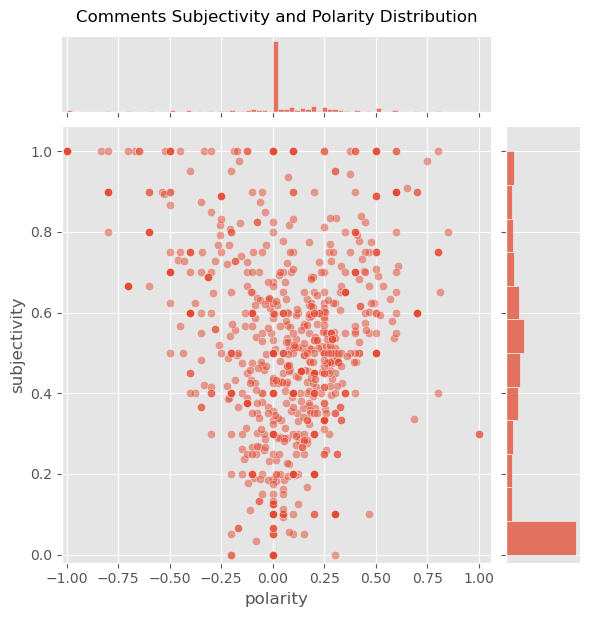

In [72]:
g = sns.jointplot(data = df_sentence_summary, 
           x = "polarity", y = "subjectivity",
        kind = "scatter", alpha = 0.5)

g.ax_marg_x.set_xlim(-1.02, 1.06)
g.ax_marg_y.set_ylim(-0.02, 1.06)

plt.suptitle("Comments Subjectivity and Polarity Distribution", y = 1.02, x = 0.47)
plt.show()

#### 📈 Comments Subjectivity and Polarity Distribution

This plot shows the distribution of Reddit comments based on their polarity (sentiment orientation) and subjectivity (degree of personal opinion).

- **Polarity**: Measures sentiment from negative (-1) to positive (+1).
- **Subjectivity**: Measures the extent of personal opinion from objective (0) to highly subjective (1).

#### 🔍 Key Observations
- Most comments are clustered around **neutral polarity (0)**, indicating a balanced or mixed sentiment.
- A significant portion of comments have **high subjectivity (0.4 to 0.8)**, suggesting that users expressed strong personal opinions about Jaguar’s logo change.
- Few comments show extreme polarities (strongly negative or strongly positive).

**Conclusion**: The discussion is largely subjective, with many users sharing personal feelings rather than purely factual statements. Overall sentiment leans slightly negative but remains close to neutral.


In [74]:
#sentiment for each comment (note: 1 comment would have more than 1 sentence)
df_comment_summary = df_1[["comment","upvotes", "comment_id", "polarity", "subjectivity"]]

# Convert columns that should be numeric to numeric, if necessary
df_comment_summary["total_votes"] = df_comment_summary.upvotes + 1
df_comment_summary["total_votes_abs"] = [abs(i) for i in df_comment_summary.total_votes]
df_comment_summary = df_comment_summary.loc[df_comment_summary.index.repeat(df_comment_summary["total_votes_abs"])]

df_comment_summary['total_votes_abs'] = pd.to_numeric(df_comment_summary['total_votes_abs'], errors='coerce')
df_comment_summary['polarity'] = pd.to_numeric(df_comment_summary['polarity'], errors='coerce')
df_comment_summary['subjectivity'] = pd.to_numeric(df_comment_summary['subjectivity'], errors='coerce')

# Select only numeric columns for the mean calculation
numeric_cols = df_comment_summary.select_dtypes(include=['number']).columns

# Group by 'comment_id' and compute the mean for numeric columns only
df_comment_summary_1 = df_comment_summary.groupby("comment_id")[numeric_cols].mean().reset_index()

# Rename the columns as needed
df_comment_summary_1.rename(columns={'polarity': 'avg_p', 'subjectivity': 'avg_s'}, inplace=True)

# Display the descriptive statistics for specific columns
df_comment_summary_1[["upvotes", "avg_p", "avg_s"]].describe().style.apply(lambda x: ['background: lightyellow' if x.avg_p > 0.092 and x.avg_p < 0.1 else '' for i in x], axis=1)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,upvotes,avg_p,avg_s
count,704.000000,704.000000,704.000000
mean,9.465909,0.024885,0.294227
std,46.435400,0.217648,0.277576
min,-27.000000,-1.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,0.000000,0.275568
75%,3.000000,0.122500,0.498810
max,748.000000,0.700000,1.000000


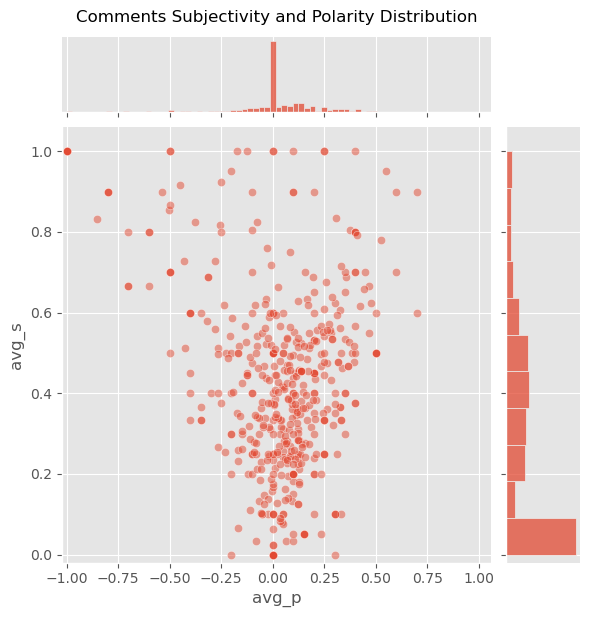

In [75]:
g = sns.jointplot(data = df_comment_summary_1, 
           x = "avg_p", y = "avg_s", kind = "scatter", alpha = 0.5)

g.ax_marg_x.set_xlim(-1.02, 1.06)
g.ax_marg_y.set_ylim(-0.02, 1.06)

plt.suptitle("Comments Subjectivity and Polarity Distribution", y = 1.02, x = 0.47)
plt.show()

#### 📈 Average Comment Subjectivity and Polarity Distribution

This scatter plot visualizes the average polarity and subjectivity scores of Reddit comments related to Jaguar’s logo change.

- **Polarity (`avg_p`)**: Indicates the overall sentiment of each comment, ranging from -1 (negative) to +1 (positive).
- **Subjectivity (`avg_s`)**: Reflects how subjective or opinionated each comment is, from 0 (objective) to 1 (highly subjective).

#### 🔍 Key Observations
- Most comments cluster around **neutral polarity (0)**, showing a balanced sentiment.
- The majority of comments have **moderate to high subjectivity (0.4–0.7)**, suggesting that users frequently shared personal opinions.
- Extreme sentiments (highly positive or highly negative) are relatively rare.

**Conclusion**: The overall discussion is moderately subjective and sentimentally balanced, with no strong polarization observed across the comments.


## NLP

In [78]:
#selecting relevant attributes/ columns 
df_nlp = df_1[["comment", "sentiment"]]
df_nlp.head()

,comment,sentiment
0,"as a former jaguar owner, i am here to say no,...",neutral
1,the new logo type feels like it wants to be at...,positive
2,"now, it might be that they want all new client...",positive
3,"a yes, the logos were certainly their biggest ...",positive
4,glad they got those fixed first.,positive


In [79]:
#tokenize
df_nlp["comment"] = df_nlp["comment"].apply(lambda x: word_tokenize(x) if isinstance(x, str) else [])
df_nlp.head()

,comment,sentiment
0,"[as, a, former, jaguar, owner, ,, i, am, here,...",neutral
1,"[the, new, logo, type, feels, like, it, wants,...",positive
2,"[now, ,, it, might, be, that, they, want, all,...",positive
3,"[a, yes, ,, the, logos, were, certainly, their...",positive
4,"[glad, they, got, those, fixed, first, .]",positive


In [80]:
#remove white/ blanks
df_nlp["comment"] = [[i for i in item if i != ""] for item in df_nlp.comment]
df_nlp.head()

,comment,sentiment
0,"[as, a, former, jaguar, owner, ,, i, am, here,...",neutral
1,"[the, new, logo, type, feels, like, it, wants,...",positive
2,"[now, ,, it, might, be, that, they, want, all,...",positive
3,"[a, yes, ,, the, logos, were, certainly, their...",positive
4,"[glad, they, got, those, fixed, first, .]",positive


In [81]:
df_nlp2 = df_nlp

In [82]:
#process sequence of words using pos_tag()
df_nlp["comment"] = [nltk.pos_tag(item) for item in df_nlp.comment]
df_nlp.head()

,comment,sentiment
0,"[(as, IN), (a, DT), (former, JJ), (jaguar, NN)...",neutral
1,"[(the, DT), (new, JJ), (logo, NN), (type, NN),...",positive
2,"[(now, RB), (,, ,), (it, PRP), (might, MD), (b...",positive
3,"[(a, DT), (yes, UH), (,, ,), (the, DT), (logos...",positive
4,"[(glad, NN), (they, PRP), (got, VBD), (those, ...",positive


In [83]:
#stemming 
s_stemmer = SnowballStemmer(language='english')

df_nlp["comment_1"] = [[s_stemmer.stem(i[0]) for i in item] for item in df_nlp.comment]
df_nlp["comment_2"] = [[i[1] for i in item] for item in df_nlp.comment]

df_nlp["comment_1"] = [[re.sub(r"[^\w']", '', i) for i in item] for item in df_nlp.comment_1]
df_nlp["comment_2"] = [[re.sub(r"[^\w']", '', i) for i in item] for item in df_nlp.comment_2]
df_nlp.head()

,comment,sentiment,comment_1,comment_2
0,"[(as, IN), (a, DT), (former, JJ), (jaguar, NN)...",neutral,"[as, a, former, jaguar, owner, , i, am, here, ...","[IN, DT, JJ, NN, NN, , VB, VBP, RB, TO, VB, UH..."
1,"[(the, DT), (new, JJ), (logo, NN), (type, NN),...",positive,"[the, new, logo, type, feel, like, it, want, t...","[DT, JJ, NN, NN, NNS, IN, PRP, VBZ, TO, VB, IN..."
2,"[(now, RB), (,, ,), (it, PRP), (might, MD), (b...",positive,"[now, , it, might, be, that, they, want, all, ...","[RB, , PRP, MD, VB, IN, PRP, VBP, DT, JJ, NNS,..."
3,"[(a, DT), (yes, UH), (,, ,), (the, DT), (logos...",positive,"[a, yes, , the, logo, were, certain, their, bi...","[DT, UH, , DT, NNS, VBD, RB, PRP, JJS, NN, ]"
4,"[(glad, NN), (they, PRP), (got, VBD), (those, ...",positive,"[glad, they, got, those, fix, first, ]","[NN, PRP, VBD, DT, VBN, RB, ]"


In [84]:
#separate each item into individual columns
df_nlp_1 = df_nlp[["sentiment", "comment_1", "comment_2"]].explode(["comment_1", "comment_2"]).explode(["comment_1", "comment_2"])
df_nlp_1.head()

,sentiment,comment_1,comment_2
0,neutral,as,IN
0,neutral,a,DT
0,neutral,former,JJ
0,neutral,jaguar,NN
0,neutral,owner,NN


In [85]:
#remove all stop words 
stop_words_lst = list(nlp.Defaults.stop_words)
df_nlp_1 = df_nlp_1[~df_nlp_1.comment_1.isin(stop_words_lst)]

In [86]:
df_nlp

,comment,sentiment,comment_1,comment_2
0,"[(as, IN), (a, DT), (former, JJ), (jaguar, NN)...",neutral,"[as, a, former, jaguar, owner, , i, am, here, ...","[IN, DT, JJ, NN, NN, , VB, VBP, RB, TO, VB, UH..."
1,"[(the, DT), (new, JJ), (logo, NN), (type, NN),...",positive,"[the, new, logo, type, feel, like, it, want, t...","[DT, JJ, NN, NN, NNS, IN, PRP, VBZ, TO, VB, IN..."
2,"[(now, RB), (,, ,), (it, PRP), (might, MD), (b...",positive,"[now, , it, might, be, that, they, want, all, ...","[RB, , PRP, MD, VB, IN, PRP, VBP, DT, JJ, NNS,..."
3,"[(a, DT), (yes, UH), (,, ,), (the, DT), (logos...",positive,"[a, yes, , the, logo, were, certain, their, bi...","[DT, UH, , DT, NNS, VBD, RB, PRP, JJS, NN, ]"
4,"[(glad, NN), (they, PRP), (got, VBD), (those, ...",positive,"[glad, they, got, those, fix, first, ]","[NN, PRP, VBD, DT, VBN, RB, ]"
...,...,...,...,...
1450,"[(i, NN), (left, VBD), (weeks, NNS), (before, ...",positive,"[i, left, week, befor, lockdown, by, coincid, ...","[NN, VBD, NNS, IN, JJ, IN, NN, PRP, VBD, RP, T..."
1451,"[(thank, NN), (you, PRP), (., .)]",neutral,"[thank, you, ]","[NN, PRP, ]"
1452,"[(i, NN), (had, VBD), (a, DT), (feeling, NN), ...",neutral,"[i, had, a, feel, it, was, ]","[NN, VBD, DT, NN, PRP, VBD, ]"
1453,"[(i, NN), (will, MD), (keep, VB), (my, PRP$), ...",positive,"[i, will, keep, my, innoc, laugh]","[NN, MD, VB, PRP, NN, NN]"


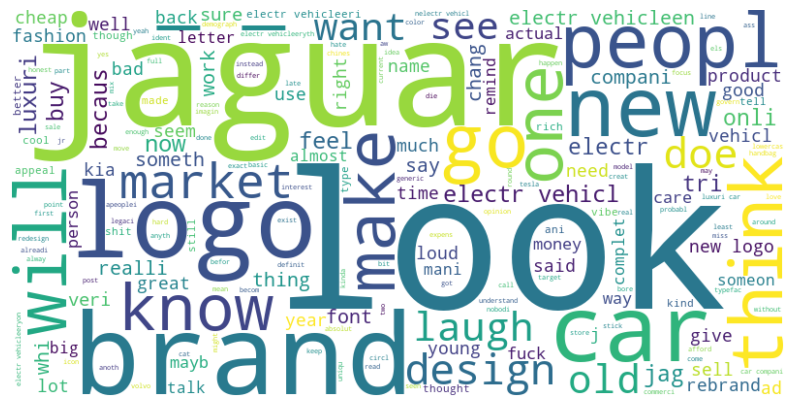

In [87]:
df_nlp['comment_1'] = df_nlp['comment_1'].apply(
    lambda x: ' '.join(x) if isinstance(x, list) else str(x)
)

jaguar_text = ' '.join(df_nlp['comment_1'].dropna())

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(jaguar_text)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### ☁️ Word Cloud Analysis

The word cloud visualizes the most frequently used words in Reddit comments related to Jaguar’s logo change.

#### 🔍 Key Observations
- **Dominant Words**: "jaguar", "look", "new", "brand", "car", "design", and "market" are the most prominent, reflecting the main focus of the discussion.
- **Themes Identified**:
  - **Visual Design**: Words like "look", "design", and "font" suggest strong attention to the new logo's appearance.
  - **Brand Perception**: Terms like "luxury", "market", and "rebrand" indicate discussions around Jaguar’s repositioning strategy.
  - **Emotional Reactions**: Words like "laugh", "feel", and "bad" point to emotional and mixed responses from the audience.

**Conclusion**: The conversation is centered around the visual impact of the new logo, the brand’s market position, and users' emotional reactions to the change.


## Top 10 Most Occuring Word

In [90]:
#grouping and counting total number of occurance for each word 
df_nlp_2 = df_nlp_1[df_nlp_1.comment_1 != ""]

df_nlp_2 = df_nlp_2.groupby(["sentiment","comment_1", "comment_2"])["comment_1"].count().reset_index(name = "total_number")
df_nlp_2.sort_values(["sentiment", "total_number"], ascending = [False, False], inplace = True)

df_nlp_2.head()

,sentiment,comment_1,comment_2,total_number
3478,positive,like,IN,95
3660,positive,new,JJ,84
3018,positive,electr,JJ,73
3500,positive,logo,NN,60
2703,positive,brand,NN,58


In [91]:
#select top 10 words from each sentiment category 
df_nlp_15 = df_nlp_2.groupby("sentiment").head(10)
df_nlp_15.reset_index(inplace = True)
df_nlp_15["comment_1_2"] = df_nlp_15["comment_1"] + " - " + df_nlp_15["comment_2"]
df_nlp_15.head()

,index,sentiment,comment_1,comment_2,total_number,comment_1_2
0,3478,positive,like,IN,95,like - IN
1,3660,positive,new,JJ,84,new - JJ
2,3018,positive,electr,JJ,73,electr - JJ
3,3500,positive,logo,NN,60,logo - NN
4,2703,positive,brand,NN,58,brand - NN


/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_10514/1793231846.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(l, fontsize=15)
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_10514/1793231846.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(l, fontsize=15)
/var/folders/88/pplf9xtd1zj3kc9l0xvw7qj40000gn/T/ipykernel_10514/1793231846.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(l, fontsize=15)


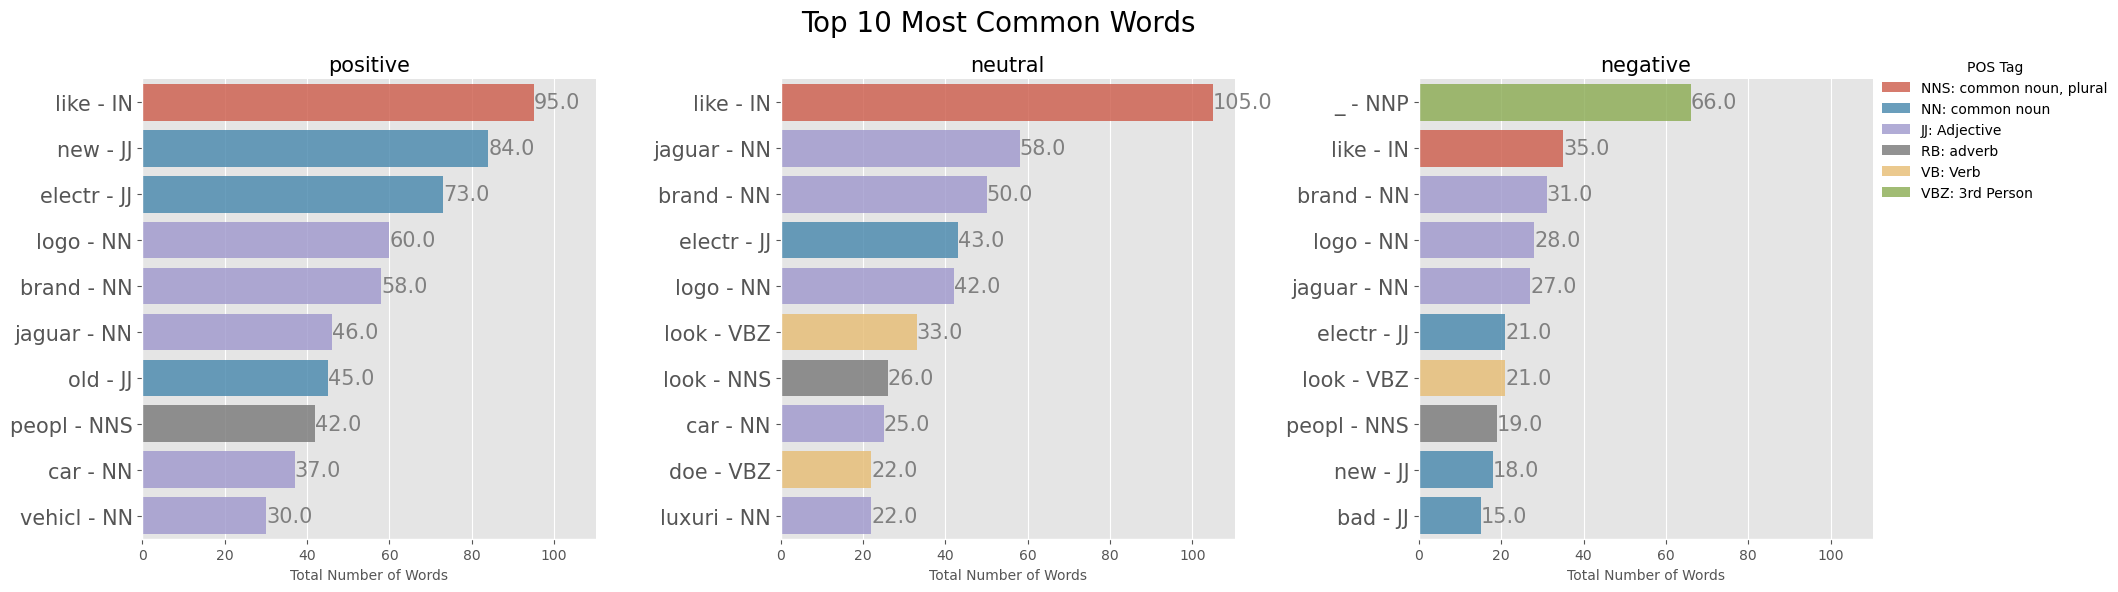

In [92]:
g = sns.catplot(data = df_nlp_15,
            x = "total_number", y = "comment_1_2",
            kind = "bar",
            hue = "comment_2",
            col = "sentiment",
            dodge = False,
            sharey = False,
            alpha = 0.8, height = 6, aspect = 1)

for ax in g.axes.ravel():
    for c in ax.containers:
        labels = [f'{v.get_width()}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', color = "grey", size = 15)

title = ["positive", "neutral", "negative"]

axes = g.axes.flatten()

for i in range(3):
    axes[i].set_title(title[i], size = 15)
    l = axes[i].get_yticklabels()
    axes[i].set_yticklabels(l, fontsize=15)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("Total Number of Words", size = 10)

new_title = 'POS Tag'
g._legend.set_title(new_title)

new_labels = ['NNS: common noun, plural', 'NN: common noun', 'JJ: Adjective', 'RB: adverb', 'VB: Verb', 'VBZ: 3rd Person', 'IN: Preposition']
for t, l in zip(g._legend.texts, new_labels):
    t.set_text(l)

g._legend.set_bbox_to_anchor((1.12, 0.77))

plt.suptitle("Top 10 Most Common Words", size = 20, x = 0.53)

plt.tight_layout()
plt.show()

#### 📊 Top 10 Most Common Words by Sentiment

These charts display the ten most frequent words used in Reddit comments categorized by sentiment polarity: positive, neutral, and negative.

- **POS Tags**: Words are annotated with their Part of Speech (e.g., noun, adjective, verb) to highlight their grammatical roles.

#### 🔍 Key Observations
- **Positive Comments**:
  - Common words include "like", "new", and "electric", emphasizing appreciation for the design and future direction.
- **Neutral Comments**:
  - Words like "Jaguar", "brand", and "logo" dominate, reflecting factual discussions about the brand and its new identity.
- **Negative Comments**:
  - Terms such as "bad", "look", and "peopl" appear more often, indicating criticism and dissatisfaction among users.

**Conclusion**:  
Discussions across all sentiments revolve around the brand, logo appearance, and the electric transition, but the tone shifts significantly with sentiment polarity.


## 📜 Final Conclusion

This analysis of Reddit comments surrounding Jaguar’s logo change on November 19, 2024, provides valuable insights into public perception and sentiment trends.

### Key Findings:
- **Sentiment Analysis**:
  - **VADER** detected a greater proportion of negative comments, indicating higher sensitivity to critical language and informal expressions.
  - **TextBlob** classified a majority of comments as neutral, suggesting a tendency towards a more conservative and less context-sensitive assessment.
  - Overall, sentiment leaned slightly negative, with the highest user engagement observed around 1 PM on the announcement day.
- **Topic Modeling**:
  - Major themes included the new logo’s visual design, the brand’s identity shift, and Jaguar's transition towards an electric future.
- **Keyword Analysis**:
  - Core terms such as "jaguar", "look", "brand", "electric", and "design" dominated the discussions, highlighting user focus on aesthetics and market positioning.

### Recommendations:
- Jaguar should proactively address negative feedback to strengthen consumer confidence and brand loyalty during its transformation.
- For future sentiment tracking, combining multiple sentiment analysis tools is recommended to capture a fuller range of public emotions.
- Extending monitoring efforts to other platforms (e.g., Twitter, Instagram) would provide a broader sentiment landscape.

This structured, multi-method NLP analysis offers critical insights into consumer reactions during a pivotal moment in Jaguar’s brand evolution.
